# Leading-edge Slat Analysis

## The History of Leading-edge Slat

We have used NACA23012 airfoil to simulate flap and analyzed the lift in different conditions, which are different deflection angles and different attack angles. So, do we know exactly what flaps are? Are flaps always set behind the airfoil? 

First, flaps are high-lifting devices, which are mounted on the trailing edge of the wing to increase the lift generated and angle of descent. And there is also another kind of flap, which is set at the leading edge, call leading-edge slat.

We know that the flap allow the wing to operate at a higher angle of attack when the flap deployed. The leading-edge play the same role as other kinds of flap. 

In 1918, Gustav Lachmann developed the first slat. The first leading-edge slat presented a patent in Germany. However, Mr. Handley Page stated that it was impossible to get a good ratio of lift to resistance and a high maxmium lift with the same section, and it is necessary to have some variable device which will affect the air flow to get both combined in one plane, and then Handley also developed the slat. 


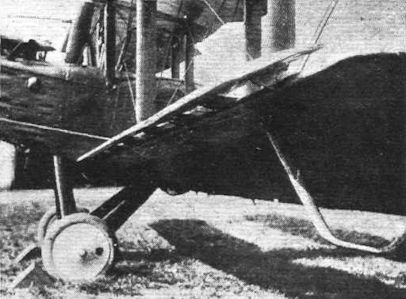

In [1]:
from IPython.display import Image
Image(filename='Handley.jpg')

During World War II, German developed a more advanced version. It allowed aircraft to take off in a light wind. The biggest aim in the earliest days was the production of a machine with a high degree of control. But accidents still occured and a big proportion were due to the pilot losing control of his machine through stalling and that is why Handley Page slot or slotted wing has been evolved. And at post world war II, slats were operated by hydraulics or electricity on larger aircraft, this is definitely one of the outstanding aeronautical development of recent years.

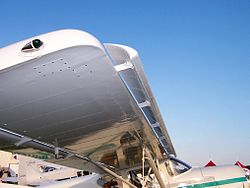

In [2]:
from IPython.display import Image
Image(filename='slatpicture.jpg')

What this project will do next is that using two-elements panel method finish the analysis of the different lift coefficient by different overhang distances, which we can take this distance as the gap between slat and main airfoil, and different deflection angles.

## Set geometry of this two-elements airfoil

In this project I set <font color='red'>NACA23012</font> as my main airfoil and I will scale the <font color='red'>CR001SM</font> down as my slat, the reason why I chose this as my slat is this airfoil is highly cambered and the result will get close to the real condition. Since we have already learned how to use panel method in class, also the vortex-source panel method will be used. Now let us import our numpy library and define panel first. 

In [3]:
import numpy
import math
from matplotlib import pyplot
from scipy import integrate
%matplotlib inline

Next, let us start to code our functions of my source-vortex panel method. And I used the points on circle porject on the geometry of the CR001SM. 

In [4]:
#Difine class for panel
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # center point
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel   
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
#Some parameter of panels        
        self.sigma = 0. # source strength
        self.vt = 0.    # tangential velocity
        self.cp = 0.    # pressure coefficient        
def define_panels(x, y, N=50):
    R = (x.max()-x.min())/2             # radius of the circle
    x_center = (x.max()+x.min())/2  
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  
    x_ends = numpy.copy(x_circle)      
    y_ends = numpy.empty_like(x_ends) 
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]  
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])   
    return panels
#Define the freestream
class Freestream:
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 
def integral(x, y, panel, deltax, deltay):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*deltax
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*deltay)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

#Define the function for vortex and source contribution
def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, panel_j,numpy.cos(panel_i.beta),numpy.sin(panel_i.beta))
    return A
def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

#Define the kutta condition at the two trailing edges
def kutta_condition(A_source, B_vortex):
    b = numpy.empty([2,A_source.shape[1]+2],dtype=float)
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]    
    b[-2,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[-2,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    b[-1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[-1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])  
    return b

#Define the matrix to solve the source and vortex strength
def build_singularity_matrix(A_source, B_vortex):
    #combine the kutta codition into A
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A
def build_freestream_rhs(panels, freestream):
    #Build the right hand side freestream array
    b = numpy.empty(panels.size+2,dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                               +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b

#Define the function to get the result
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2        
def compute_tangential_velocity(panels, freestream, gamma_slat,gamma_main, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels],gamma_slat)
    strengths = numpy.append(strengths,gamma_main)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]        

In order to get the geometry of the slat and main airfoil, what I am doing next is scale the CR001SM down, rotate an angle to let this perform as a slat. After all of this, let us combine them as my two-element airfoil.

In [5]:
with open ('10023012.csv') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float,delimiter=',', unpack=True)
with open ('cr001sm.csv') as file_name:
    xslat, yslat = numpy.loadtxt(file_name, dtype=float,delimiter=',', unpack=True)

In [6]:
#Define the rotate function
def rotation(x1,y1,theta,x,y):
    x_1,y_1=x-x1,y-y1
    theta1=theta*numpy.pi/180
    x_result=x_1*numpy.cos(theta1)+y_1*numpy.sin(theta1)+x1
    y_result=x_1*(-1)*numpy.sin(theta1)+y_1*numpy.cos(theta1)+y1
    return x_result,y_result

Since the slat usually takes about 20% of the main airfoil, so I decide to scale the geometry of CR001SM 20% down. After that I will choose the point of trailing edge of the slat, rotate around it as negative 20 degree.

Also, I select different overhangs and different deflection angles to have a look at the pressure coefficient and the lift in different conditions.

In [7]:
xslat,yslat=xslat/5,yslat/5
xslat=xslat -0.11
xslat1=xslat-0.12
yslat1=yslat
xslat,yslat=rotation(xslat[39],yslat[39],-20,xslat,yslat)
xslat1,yslat1=rotation(xslat1[39],yslat1[39],-20,xslat1,yslat1)
xslat2,yslat2=rotation(xslat[39],yslat[39],-25,xslat,yslat)

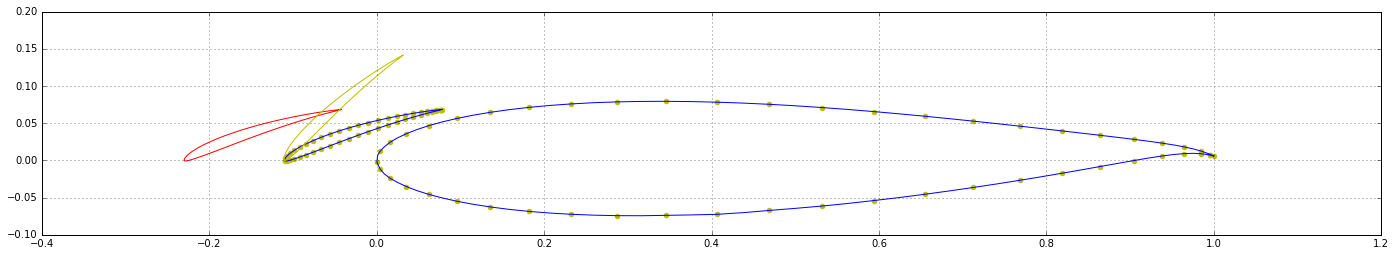

In [8]:
N = 50 # number of panels
panels_slat = define_panels(xslat, yslat, N)   # discretizes of the slat geometry into panels
panels_slat1= define_panels(xslat1,yslat1,N)   #incrase the overhang and discretizes of the slat geometry into panels
panels_slat2= define_panels(xslat2,yslat2,N)   #incrase the deflection angel and discretizes of the salt geometry into panels
panels_main = define_panels(xmain, ymain, N)   # discretizes of the main airfoil geometry into panels 
size = 10
pyplot.figure(figsize=(24,4))
pyplot.grid(True)
pyplot.plot(xmain, ymain, color='b', linestyle='-', linewidth=1);
pyplot.plot(xslat, yslat, color='b', linestyle='-', linewidth=1);
pyplot.plot(xslat1,yslat1, color='r', linestyle='-', linewidth=1);
pyplot.plot(xslat2,yslat2, color='y', linestyle='-', linewidth=1);
pyplot.scatter([panel.xa for panel in panels_main], [panel.ya for panel in panels_main], color='y');
pyplot.scatter([panel.xa for panel in panels_slat], [panel.ya for panel in panels_slat], color='y');

In [9]:
#Set the freestream
u_inf,alpha=1,-5*math.pi/180
freestream = Freestream(u_inf,alpha)

In [10]:
#Get the matrix of A and solve the matrix to get the strength of vortex and source
panels=numpy.empty(N*2, dtype=object)
panels=numpy.append(panels_slat,panels_main)
panels1=numpy.append(panels_slat1,panels_main)
panels2=numpy.append(panels_slat2,panels_main)

A_source=source_contribution_normal(panels)
A_source1=source_contribution_normal(panels1)
A_source2=source_contribution_normal(panels2)

B_vortex= vortex_contribution_normal(panels)
B_vortex1=vortex_contribution_normal(panels1)
B_vortex2=vortex_contribution_normal(panels2)

A = build_singularity_matrix(A_source, B_vortex)
A1= build_singularity_matrix(A_source1,B_vortex1)
A2= build_singularity_matrix(A_source2,B_vortex2)

b = build_freestream_rhs(panels,freestream)
b1= build_freestream_rhs(panels1,freestream)
b2= build_freestream_rhs(panels2,freestream)

strengths = numpy.linalg.solve(A, b)
strengths1= numpy.linalg.solve(A1,b1)
strengths2= numpy.linalg.solve(A2,b2)

In [11]:
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma_slat = strengths[-2]
gamma_main = strengths[-1]
for i , panel in enumerate(panels1):
    panel.sigma = strengths1[i]
gamma_slat1 = strengths1[-2]
gamma_main1 = strengths1[-1]
for i , panel in enumerate(panels2):
    panel.sigma = strengths2[i]
gamma_slat2 = strengths2[-2]
gamma_main2 = strengths2[-1]

compute_tangential_velocity(panels, freestream, gamma_slat,gamma_main, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
compute_tangential_velocity(panels1, freestream, gamma_slat1,gamma_main1, A_source1, B_vortex1)
compute_pressure_coefficient(panels1, freestream)
compute_tangential_velocity(panels2, freestream, gamma_slat2,gamma_main2, A_source2, B_vortex2)
compute_pressure_coefficient(panels2, freestream)

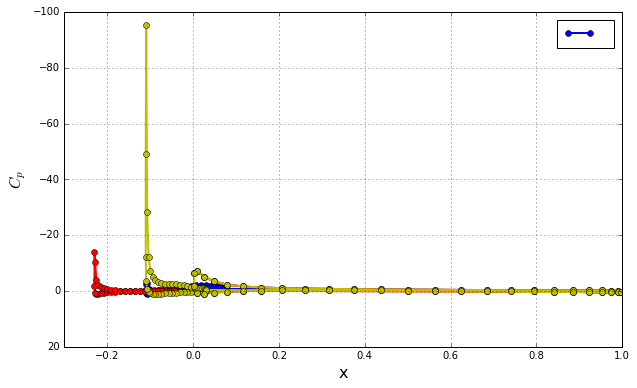

In [12]:
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels], [panel.cp for panel in panels],color='b', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels1], [panel.cp for panel in panels1],color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels2], [panel.cp for panel in panels2],color='y', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.title('', fontsize=16)
pyplot.legend([''], loc='best', prop={'size':16})
pyplot.xlim(-0.3, 1)
pyplot.gca().invert_yaxis();

In [13]:
Lift_1,Drag_1=0,0
for panel in panels:
    Lift_1 -=panel.cp*numpy.sin(panel.beta)*panel.length
    Drag_1 +=panel.cp*numpy.cos(panel.beta)*panel.length

In [14]:
Lift_1

1.0170605141085334